# Lending Club Loan Data - Exploratory Data Analysis

Before beginning our modeling, per usual, 
let's do some iniital EDA to really understand the data we our working with!

In [1]:
import os
import re
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
sns.set(style="darkgrid")
%matplotlib inline

Before beginning our EDA, let's get some of those handy formatters in place to make those fresh and clean columns

In [2]:
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0fM' % (x*1e-6)
mil_fmt = FuncFormatter(millions)

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x*1e-3)
k_fmt = FuncFormatter(thousands)

def percent(x, pos):
    return '{:,.2%}'.format(x)
percent_formatter = FuncFormatter(percent)

In [3]:
data_dict = pd.read_excel('data/LCDataDictionary.xlsx')

df = (pd.read_csv('data/loan.csv', low_memory=False)
      .set_index('id')
      .assign(issue_d=lambda x: x.issue_d.astype('datetime64')))

In [4]:
shape = ['{:,d}'.format(x) for x in df.shape]
print("There are {} records in this dataset and {} potential features".format(*shape))

There are 887,379 records in this dataset and 73 potential features


Woah, that's a lot of features. Let's dig into these to see what we're working with.

## Loan Status

First our most importantly, we'll take a peak at our dependent variable, loan status.

Below is the distribution across the years


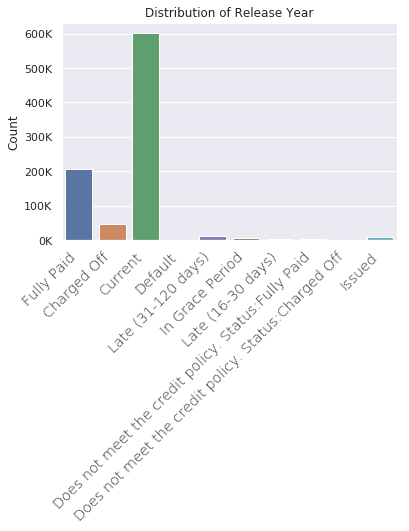

In [5]:
print("Below is the distribution across the years")
x = df.loan_status
ax = sns.countplot(x)
ax.set(xlabel="", ylabel="Count", title="Distribution of Release Year")
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.yaxis.set_major_formatter(k_fmt)
plt.show()

After doing a little research on Lending Club's site, 
* **_Default_**:     120 days past due
* **_Charged Off_**: 150 days past due

In [6]:
counts = (df.loan_status.value_counts().rename('Count'))
percents = (df.loan_status.value_counts(normalize=True).rename('Frequency'))
(pd.concat([counts, percents], axis=1)
 .assign(Count=lambda x: x.Count.map(lambda x: '{0:,}'.format(x)),
         Frequency=lambda x: x.Frequency.map(lambda x: '{0:,.2%}'.format(x))))

,Count,Frequency
Current,"601,779",67.82%
Fully Paid,"207,723",23.41%
Charged Off,"45,248",5.10%
Late (31-120 days),"11,591",1.31%
Issued,"8,460",0.95%
In Grace Period,"6,253",0.70%
Late (16-30 days),"2,357",0.27%
Does not meet the credit policy. Status:Fully Paid,"1,988",0.22%
Default,"1,219",0.14%
Does not meet the credit policy. Status:Charged Off,761,0.09%


We'll ignore those with **_Does not meet the credit policy_** and those labels **_Issued_**, since both are such a small percentage.

We'll ignore **_Current_** as well since those could end up either defaulting or paying, but we don't know yet,
but we can eventually try and predict these and see how they come out over time with our final model!

Otherwise, we have 200k **_Fully Paid_** loans. Since there are only one thousand (0.14%) **_Default_** loans,
we will combine **_Late (31-120 days)_** and **_Charged Off_**, assuming these loans will default or at least need to restructure. This means we are defining default as **_a loan at least 30 days past due_**.

To me, **_Late (16-30 days)_** are too up in the air as well, so we'll exclude those for now. 

Let's check out our new numbers.

In [7]:
loan_status_lst = ['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Default']
mask = df.loan_status.isin(loan_status_lst)
df = df.loc[mask, :]

In [8]:
shape = ['{:,d}'.format(x) for x in df.shape]
print("There are now {} records in this dataset and still {} potential features".format(*shape))
counts = (df.loan_status.value_counts().rename('Count'))
percents = (df.loan_status.value_counts(normalize=True).rename('Frequency'))
(pd.concat([counts, percents], axis=1)
 .assign(Count=lambda x: x.Count.map(lambda x: '{0:,}'.format(x)),
         Frequency=lambda x: x.Frequency.map(lambda x: '{0:,.2%}'.format(x))))

There are now 265,781 records in this dataset and still 73 potential features


,Count,Frequency
Fully Paid,"207,723",78.16%
Charged Off,"45,248",17.02%
Late (31-120 days),"11,591",4.36%
Default,"1,219",0.46%


Now we have 250k records with an 80/20 split in our target, assuming we re-label everything but **_Fully Paid_** as 1.

## Issue Date

In [9]:
date_range = [df.issue_d.min(), df.issue_d.max()]
date_range_str = tuple([x.strftime('%B %Y') for x in date_range])
date_interval = (date_range[1].year - date_range[0].year)
print("Our loan were issued between %s and %s" % date_range_str)
print("This is approximately an %d year range" % date_interval)

Our loan were issued between June 2007 and December 2015
This is approximately an 8 year range


In [10]:
(df.groupby('loan_status')['issue_d'].max()
 .rename('Max-Issue Date')
 .sort_values()
 .pipe(pd.DataFrame))

,Max-Issue Date
loan_status,
Default,2015-08-01
Charged Off,2015-09-01
Late (31-120 days),2015-11-01
Fully Paid,2015-12-01


That's a pretty wide range! Let's look at the distribution by year.

Below is the distribution across the years


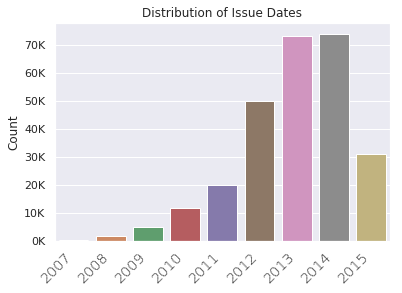

In [11]:
print("Below is the distribution across the years")
x = df.issue_d.dt.year
xticks = np.sort(x.unique())
ax = sns.countplot(x)
ax.set(xlabel="", ylabel="Count", title="Distribution of Issue Dates")
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.yaxis.set_major_formatter(k_fmt)
plt.show()

Most of these loans were made between 2012 - 2014.

Below is the distribution across month


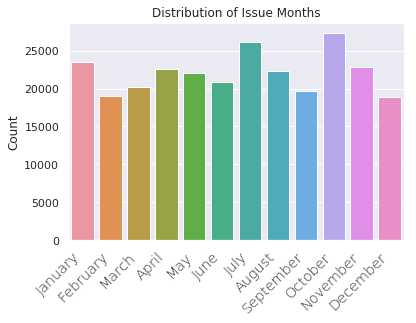

In [12]:
print("Below is the distribution across month")
x = df.issue_d.dt.month
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']
xticks = np.sort(x.unique())
ax = sns.countplot(x)
ax.set(xlabel="", ylabel="Count", title="Distribution of Issue Months")
ax.set_xticklabels(month_names, 
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
plt.show()

Pretty even, with **_January_**, **_July_** and **_October_** being the three highest months. 


January makes sense, but wonder why August and October? 
Maybe there's something we can dig into there within the **_purpose_** and **_description_** fields.

This chart is interesting because it shows some heavy variation though across time.


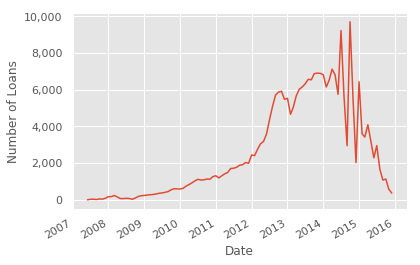

In [13]:
print("This chart is interesting because it shows some heavy variation though "
      "across time.")
plt.style.use('ggplot')
ax = df.issue_d.value_counts().plot()
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Loans')
plt.show()

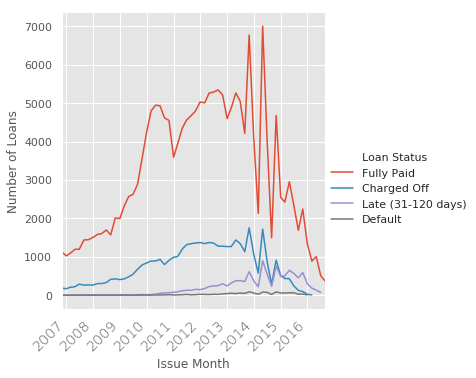

In [14]:
data = (df.groupby(['issue_d', 'loan_status']).size()
        .reset_index(name='count')
        .rename(columns={'count': 'Number of Loans', 'loan_status': 'Loan Status',
                         'issue_d': 'Issue Month'}))
rp = sns.relplot(x='Issue Month', y='Number of Loans', hue='Loan Status', data=data, kind="line")
ax = rp.axes[0, 0]
ax.set_xlim(dt.datetime(2011, 1, 1), dt.datetime(2015, 12, 1))
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
plt.show()

## Grade

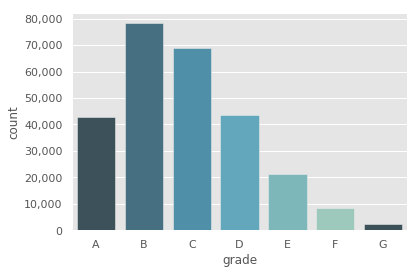

In [15]:
order = (df.grade.drop_duplicates()
         .sort_values()
         .values
         .tolist())
ax = sns.countplot('grade', data=df, order=order, palette=sns.color_palette("GnBu_d"))
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

Most of our grades are good but let's look at some three dimension data of **_Grade_** and **_Loan Status_**.

In [16]:
pivot = df.groupby(['grade', 'loan_status']).size().unstack('loan_status')
(pivot.style
 .background_gradient(cmap=plt.get_cmap('PiYG'))
 .applymap('{:,d}'.format))

loan_status,Charged Off,Default,Fully Paid,Late (31-120 days)
grade,,,,
A,2617,47,39679,492
B,9519,198,66546,2004
C,12642,360,52678,3339
D,10486,312,30020,2890
E,6258,201,12928,1852
F,2934,79,4726,768
G,792,22,1146,246


In [17]:
pivot.div(pivot.sum(axis=1), axis=0).applymap('{:0.2%}'.format)

loan_status,Charged Off,Default,Fully Paid,Late (31-120 days)
grade,,,,
A,6.11%,0.11%,92.63%,1.15%
B,12.16%,0.25%,85.02%,2.56%
C,18.32%,0.52%,76.32%,4.84%
D,23.99%,0.71%,68.68%,6.61%
E,29.46%,0.95%,60.87%,8.72%
F,34.49%,0.93%,55.55%,9.03%
G,35.90%,1.00%,51.95%,11.15%


In [18]:
pivot.div(pivot.sum(axis=0), axis=1).applymap('{:0.2%}'.format)

loan_status,Charged Off,Default,Fully Paid,Late (31-120 days)
grade,,,,
A,5.78%,3.86%,19.10%,4.24%
B,21.04%,16.24%,32.04%,17.29%
C,27.94%,29.53%,25.36%,28.81%
D,23.17%,25.59%,14.45%,24.93%
E,13.83%,16.49%,6.22%,15.98%
F,6.48%,6.48%,2.28%,6.63%
G,1.75%,1.80%,0.55%,2.12%


They're clearly doing a good job with these grades. Kudos, Lending Club.

## Loan Amount

In [19]:
(df.loan_amnt.describe()
 .pipe(pd.DataFrame)
 .applymap('{:,.0f}'.format))

,loan_amnt
count,"265,781"
mean,"13,658"
std,"8,161"
min,500
25%,"7,500"
50%,"12,000"
75%,"18,550"
max,"35,000"


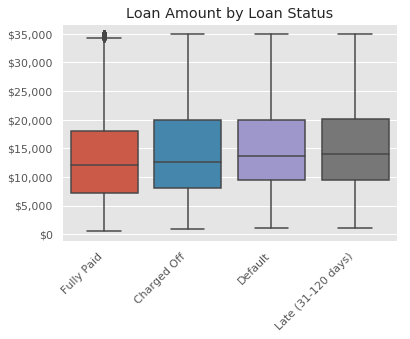

In [20]:
ax = sns.boxplot(x='loan_status', y='loan_amnt', data=df)
plt.xticks(rotation=45, ha='right')
ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set(title='Loan Amount by Loan Status', xlabel="", ylabel="")
plt.show()

Unsuprisingly, _Fully Paid_ loans are have slightly lower loan amounts.

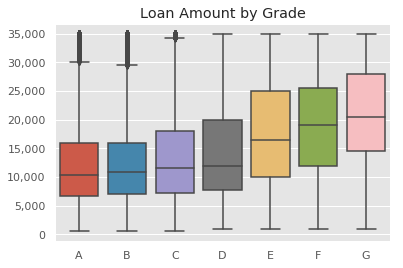

In [21]:
order = (df.grade.drop_duplicates()
         .sort_values()
         .values
         .tolist())
ax = sns.boxplot(x='grade', y='loan_amnt', data=df, order=order)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set(title='Loan Amount by Grade', xlabel="", ylabel="")
plt.show()

We can clearly see average loan amount increases as grade decreases.

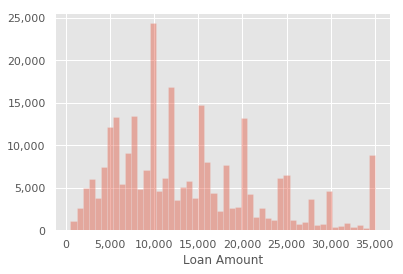

In [22]:
ax = sns.distplot(df.loan_amnt.values.round().astype('int64'), kde=False)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Loan Amount')
plt.show()

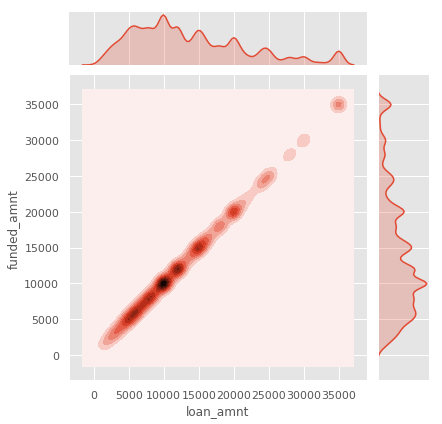

In [23]:
sns.jointplot(x="loan_amnt", y="funded_amnt", data=df, kind="kde")

## Interest Rate

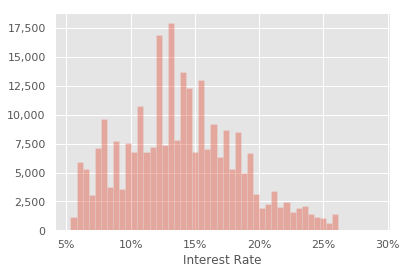

In [24]:
ax = sns.distplot(df.int_rate, kde=False)
ax.set_xticklabels(['{:}%'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Interest Rate')
plt.show()

In [25]:
ir_range = (df.int_rate.min(), df.int_rate.max())
print("Our interest rates range from {:0.2f}% to {:0.2f}%".format(*ir_range))

Our interest rates range from 5.32% to 28.99%


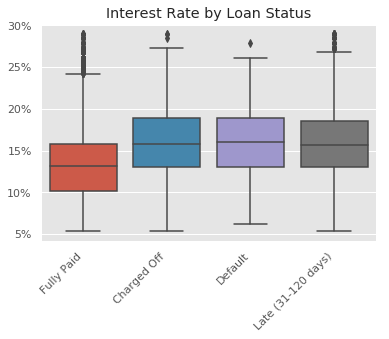

In [26]:
ax = sns.boxplot(x='loan_status', y='int_rate', data=df)
plt.xticks(rotation=45, ha='right')
ax.set_yticklabels(['{:,}%'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set(title='Interest Rate by Loan Status', xlabel="", ylabel="")
plt.show()

Our default loans unsuprisingly have a higher interest rate as well.

## Installment

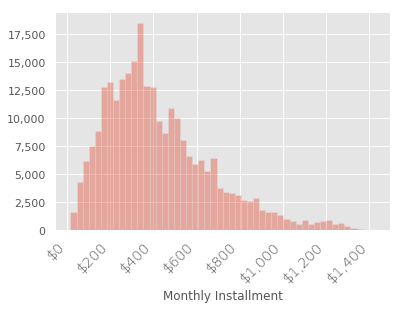

In [27]:
ax = sns.distplot(df.installment, kde=False)
ax.set_xticklabels(['${:,.0f}'.format(int(x)) for x in ax.get_xticks().tolist()],
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Monthly Installment')
plt.show()

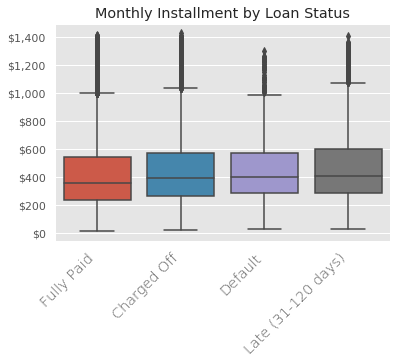

In [28]:
ax = sns.boxplot(x='loan_status', y='installment', data=df)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.set_yticklabels(['${:,.0f}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set(title='Monthly Installment by Loan Status', xlabel="", ylabel="")
plt.show()

Most installments are between ``$200 and $600`` and get slightly higher for our defaulters.

## Inquiries in the Last 6 months

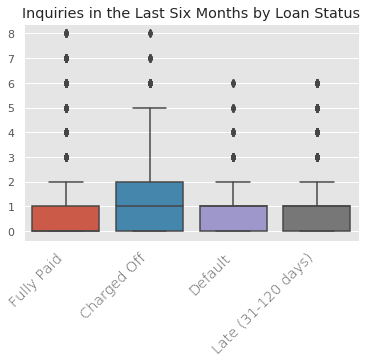

In [29]:
ax = sns.boxplot(x='loan_status', y='inq_last_6mths', data=df)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.set(title='Inquiries in the Last Six Months by Loan Status', xlabel="", ylabel="")
plt.show()

Woah, that's a lot of outliers. Let's do a little zoom in without those.

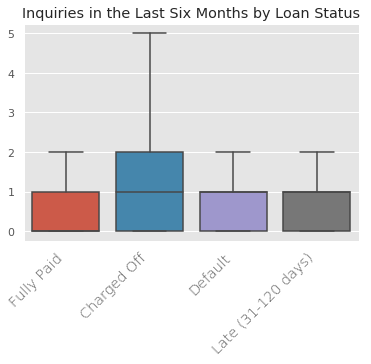

In [30]:
ax = sns.boxplot(x='loan_status', y='inq_last_6mths', data=df, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.set(title='Inquiries in the Last Six Months by Loan Status', xlabel="", ylabel="")
plt.show()

## Purpose

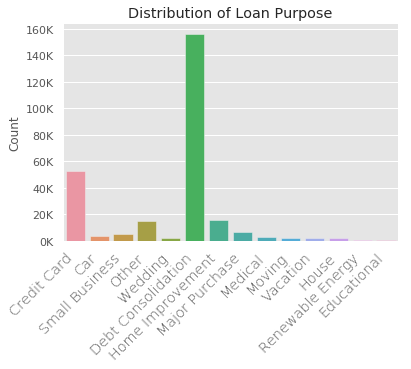

In [31]:
x = df.purpose.str.replace("_", " ").str.title()
ax = sns.countplot(x)
ax.set(xlabel="", ylabel="Count", title="Distribution of Loan Purpose")
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.yaxis.set_major_formatter(k_fmt)
plt.show()

Woah, that's a lot of outliers. Let's do a little zoom in without those.

## Inquiries

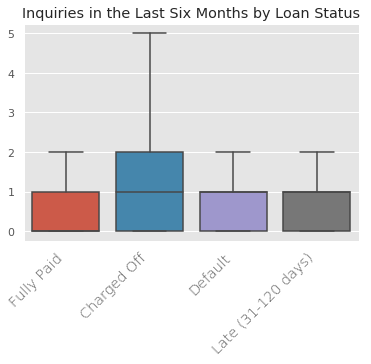

In [32]:
ax = sns.boxplot(x='loan_status', y='inq_last_6mths', data=df, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.set(title='Inquiries in the Last Six Months by Loan Status', xlabel="", ylabel="")
plt.show()

Most of these loans were either for **_Debt Consolidation_** or **_Credit Card_** debt.

Woah, that's a lot of outliers. Let's do a little zoom in without those.

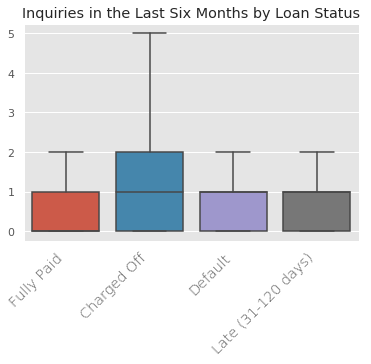

In [33]:
ax = sns.boxplot(x='loan_status', y='inq_last_6mths', data=df, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.set(title='Inquiries in the Last Six Months by Loan Status', xlabel="", ylabel="")
plt.show()

## DTI

**_DTI_** is defined here as:
    
    "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
    
It is a great measure of someone's ability to pay their debt. Let's look at it's distribution across each loan status.

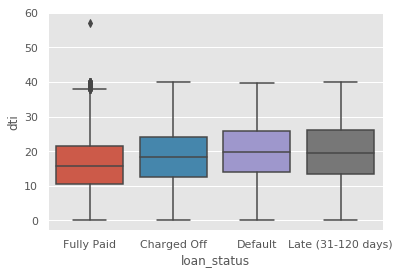

In [34]:
sns.boxplot(x='loan_status', y='dti', data=df)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.set(title='DTI by Loan Status', xlabel="", ylabel="")
plt.show()

## Application Type

In [35]:
(df.application_type.value_counts()
 .rename('Count')
 .pipe(pd.DataFrame))

,Count
INDIVIDUAL,265778
JOINT,3


Since there are only three joint loans left we'll get rid of those.

In [36]:
mask = df.application_type == 'INDIVIDUAL'
df = df.loc[mask, :]

## Term

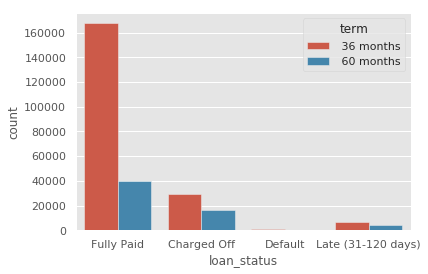

In [37]:
sns.countplot(x='loan_status', hue='term', data=df)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
plt.show()

**_3 year loans_** are a higher proportion in the _Fully Paid_ loans.

## Annual Income

In [38]:
(df.verification_status.value_counts()
 .rename("Count")
 .pipe(pd.DataFrame)
 .applymap('{:,}'.format))

,Count
Verified,"97,719"
Not Verified,"88,863"
Source Verified,"79,196"


Only about a third are verified. A random forest should be able to handle this but if we are using
income in our logistic regression we'll want to make sure either we filter not verified loans or
always include both columns in our model.

In [39]:
(df.annual_inc.describe()
 .pipe(pd.DataFrame)
 .applymap('{:,.0f}'.format))

,annual_inc
count,"265,778"
mean,"72,402"
std,"58,332"
min,"3,000"
25%,"45,000"
50%,"62,000"
75%,"87,000"
max,"8,706,582"


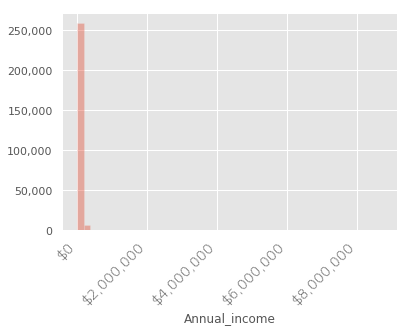

In [40]:
ax = sns.distplot(df.annual_inc, kde=False)
ax.set_xticklabels(['${:,.0f}'.format(int(x)) for x in ax.get_xticks().tolist()],
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Annual_income')
plt.show()

That's a heavy skew. Guess we have some higher earners in here.

In [41]:
bins = [x * 1000000 for x in range(0, 10)]
(df.annual_inc
 .pipe(pd.cut, bins=bins)
 .value_counts()
 .rename('Count')
 .pipe(pd.DataFrame)
 .applymap('{:,d}'.format))

,Count
"(0, 1000000]","265,741"
"(1000000, 2000000]",28
"(5000000, 6000000]",2
"(4000000, 5000000]",2
"(8000000, 9000000]",1
"(7000000, 8000000]",1
"(6000000, 7000000]",1
"(3000000, 4000000]",1
"(2000000, 3000000]",1


In [42]:
(df.loc[df.loan_status != 'Fully Paid', ['loan_status', 'loan_amnt', 'annual_inc']]
 .nlargest(15, 'annual_inc')
 .assign(annual_inc=lambda x: x.annual_inc.map('${:,.0f}'.format),
         loan_amnt=lambda x: x.loan_amnt.map('${:,.0f}'.format)))

,loan_status,loan_amnt,annual_inc
id,,,
39429853,Charged Off,"$8,000","$8,706,582"
57186441,Late (31-120 days),"$35,000","$1,650,000"
50456954,Default,"$35,000","$1,300,000"
830027,Late (31-120 days),"$15,775","$1,250,000"
8565472,Charged Off,"$18,000","$932,000"
35256623,Charged Off,"$19,225","$900,000"
514680,Charged Off,"$12,000","$840,000"
3604894,Charged Off,"$30,000","$800,000"
1576607,Charged Off,"$16,000","$800,000"


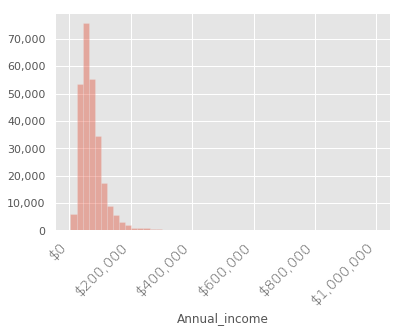

In [43]:
mask = df.annual_inc < 1000000
x = df.loc[mask, 'annual_inc']
ax = sns.distplot(x, kde=False)
ax.set_xticklabels(['${:,.0f}'.format(int(x)) for x in ax.get_xticks().tolist()],
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Annual_income')
plt.show()

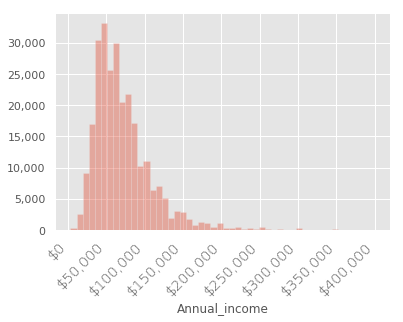

In [44]:
mask = df.annual_inc < 400000
x = df.loc[mask, 'annual_inc']
ax = sns.distplot(x, kde=False)
ax.set_xticklabels(['${:,.0f}'.format(int(x)) for x in ax.get_xticks().tolist()],
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Annual_income')
plt.show()

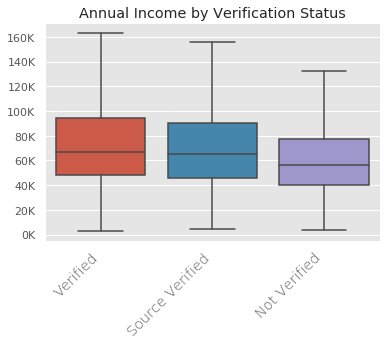

In [45]:
ax = sns.boxplot(x='verification_status', y='annual_inc', data=df, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
ax.set(title='Annual Income by Verification Status', xlabel="", ylabel="")
ax.yaxis.set_major_formatter(k_fmt)
plt.show()

## Scatterplots

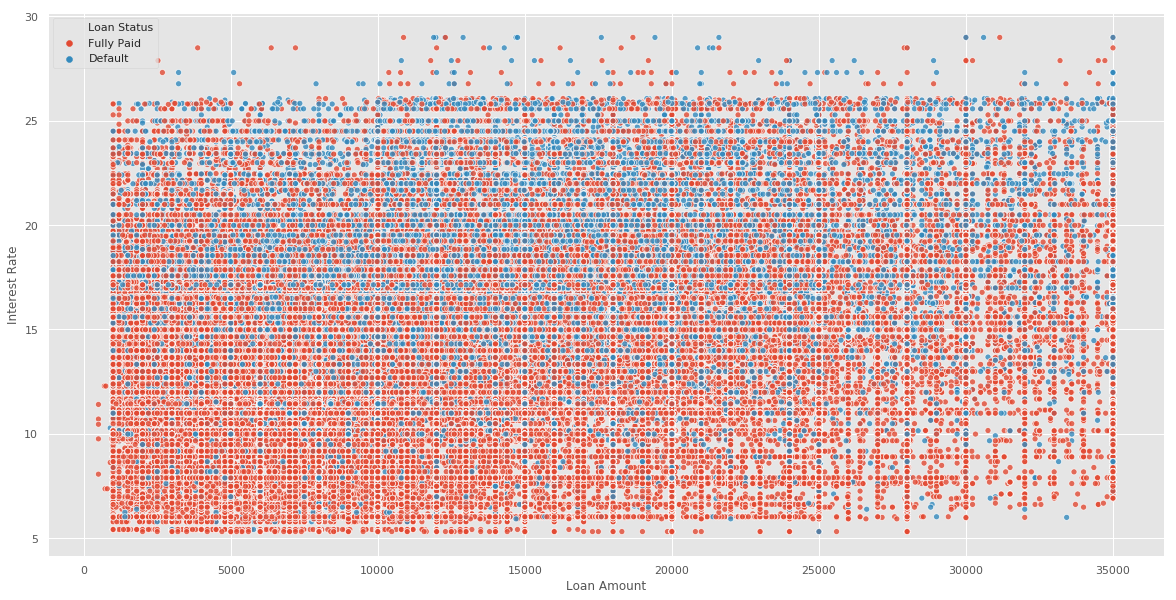

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))
mask = df.loan_status == 'Fully Paid'
data = (df.loc[:, ['loan_amnt', 'int_rate', 'loan_status']]
        .assign(loan_status=lambda x: x.loan_status.where(mask, 'Default'))
        .rename(columns={'loan_status': 'Loan Status'}))
markers = {"Fully Paid": ".", "Default": "X"}
sizes = {"Fully Paid": 20, "Default": 50}
sns.scatterplot(x='loan_amnt', y='int_rate', hue='Loan Status', data=data, ax=ax, markers=markers, alpha=0.8,
                sizes=sizes)
ax.set(xlabel="Loan Amount", ylabel="Interest Rate")
plt.show()

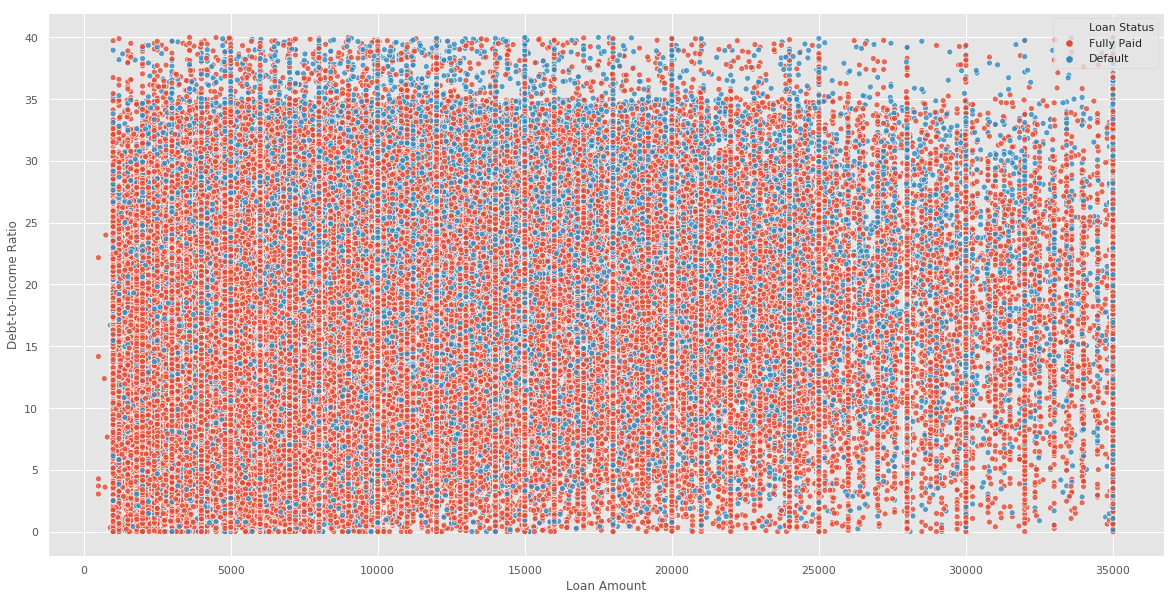

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
mask = df.loan_status == 'Fully Paid'
x = 'loan_amnt'
y = 'dti'
data = (df.loc[:, [x, y, 'loan_status']]
        .assign(loan_status=lambda x: x.loan_status.where(mask, 'Default'))
        .rename(columns={'loan_status': 'Loan Status'}))
markers = {"Fully Paid": ".", "Default": "X"}
sizes = {"Fully Paid": 20, "Default": 50}
sns.scatterplot(x=x, y=y, hue='Loan Status', data=data, ax=ax, markers=markers, alpha=0.8,
                sizes=sizes)
ax.set(xlabel="Loan Amount", ylabel="Debt-to-Income Ratio")
plt.show()